<a href="https://colab.research.google.com/github/oyaon/Machine-Learning-Using-Python/blob/main/LSTMandProphetDhaka1524.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

predicting rainfall as a continuous variable, MSE, MAE, RMSE would be relevant.

# LSTM (Long Short-Term Memory)

Preprocess Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv("Dhaka1524.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Fix humidity anomalies (replace values <20% with mean)
df["Humidity"] = df["Humidity"].apply(lambda x: df["Humidity"].mean() if x < 20 else x)

# Feature engineering
df["Month"] = df.index.month
df["DayOfYear"] = df.index.dayofyear

# Select features and target
features = ["TempMax", "TempMin", "Humidity", "Month", "DayOfYear"]
target = "Rainfall"
data = df[features + [target]]

# Normalize data (LSTMs require scaled inputs)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split into sequences (e.g., use 7 days to predict the next day)
sequence_length = 7
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length, :-1])  # Input: 7 days of features
    y.append(scaled_data[i+sequence_length, -1])     # Output: Rainfall on day 8

X = np.array(X)
y = np.array(y)

# Train-test split (80-20)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build and Train the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0082
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0072
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0055 - val_loss: 0.0071
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - va

 Evaluate and Predict

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse scaling to get actual rainfall values
y_pred_actual = scaler.inverse_transform(np.concatenate([X_test[:, -1, :], y_pred.reshape(-1,1)], axis=1))[:, -1]
y_test_actual = scaler.inverse_transform(np.concatenate([X_test[:, -1, :], y_test.reshape(-1,1)], axis=1))[:, -1]

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"RMSE: {rmse:.2f} mm")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
RMSE: 15.04 mm


## Prophet (by Meta)
Prophet is designed for time-series forecasting with built-in handling of seasonality and holidays.

## Prepare Data for Prophet

In [ ]:
from prophet import Prophet

# Prophet requires columns "ds" (date) and "y" (target)
prophet_df = df.reset_index()[["Date", "Rainfall", "TempMax", "TempMin", "Humidity"]]
prophet_df.columns = ["ds", "y", "TempMax", "TempMin", "Humidity"]

# Split train-test
train_size = int(0.8 * len(prophet_df))
train = prophet_df.iloc[:train_size]
test = prophet_df.iloc[train_size:]

Train Prophet with Additional Regressors

In [ ]:
# Initialize model with regressors
model = Prophet(
    yearly_seasonality=True,   # Capture annual patterns
    weekly_seasonality=True,   # Capture weekly patterns
    daily_seasonality=False    # Disable daily (not needed here)
)

# Add external regressors (temperature, humidity)
model.add_regressor("TempMax")
model.add_regressor("TempMin")
model.add_regressor("Humidity")

# Fit the model
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/99vh7gx8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/8yd1fzfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42124', 'data', 'file=/tmp/tmp_hbh5ddz/99vh7gx8.json', 'init=/tmp/tmp_hbh5ddz/8yd1fzfc.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelfg9xxu84/prophet_model-20250301180512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predict and Evaluate

In [ ]:
# Create future dataframe with regressors
future = model.make_future_dataframe(periods=len(test), freq="D")
future = future.merge(prophet_df[["ds", "TempMax", "TempMin", "Humidity"]], on="ds")

# Generate forecasts
forecast = model.predict(future)

# Compare predictions to test data
predicted = forecast.iloc[-len(test):]["yhat"]
actual = test["y"]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"RMSE: {rmse:.2f} mm")

RMSE: 14.35 mm


## Hyperparameter Tuning
## For LSTM

##Example using Keras Tuner
hyperparameters to optimize:

Number of LSTM layers/units

Sequence length (look-back window)

Dropout rate

Batch size

Learning rate

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam

def build_lstm_model(hp):
    model = Sequential()

    # Tune LSTM units and dropout
    model.add(LSTM(
        units=hp.Int("lstm_units", min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))

    # Add a second LSTM layer (optional)
    if hp.Boolean("add_second_lstm"):
        model.add(LSTM(
            units=hp.Int("second_lstm_units", min_value=32, max_value=64, step=32)
        ))
        model.add(Dropout(hp.Float("second_dropout_rate", min_value=0.1, max_value=0.3, step=0.1)))

    model.add(Dense(1))

    # Tune learning rate
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate), loss="mse")

    return model

# Initialize tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=10,
    directory="lstm_tuning",
    project_name="rainfall_prediction"
)

# Search with FIXED batch size (do not tune batch_size here)
tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,  # Fixed batch size (or pass a list to try manually)
    validation_split=0.1,
    verbose=1
)

# Retrieve best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 32s]
val_loss: 0.007573752198368311

Best val_loss So Far: 0.0065565998665988445
Total elapsed time: 00h 10m 15s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#For Prophet
Key hyperparameters:

Seasonality modes (yearly, weekly, daily)

Changepoint prior scale (controls trend flexibility)

Holidays/events

Example tuning Prophet’s seasonality:



In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
# Import ParameterGrid
from sklearn.model_selection import ParameterGrid

param_grid = {
    "yearly_seasonality": [True, False],
    "changepoint_prior_scale": [0.01, 0.1, 0.5],
    "seasonality_mode": ["additive", "multiplicative"]
}

best_rmse = float("inf")
best_params = {}

for params in ParameterGrid(param_grid):
    model = Prophet(**params).add_seasonality(
        name="monsoon",
        period=180,
        fourier_order=10,
        prior_scale=0.1
    )
    model.fit(train)
    df_cv = cross_validation(model, initial="1000 days", period="180 days", horizon="90 days")
    df_p = performance_metrics(df_cv)
    rmse = df_p["rmse"].mean()
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print(f"Best parameters: {best_params}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/5scv3dhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/pdd31qom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23911', 'data', 'file=/tmp/tmp_hbh5ddz/5scv3dhi.json', 'init=/tmp/tmp_hbh5ddz/pdd31qom.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelqs09gra7/prophet_model-20250301182906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 11 forecasts with cutoffs between 2017-10-28 00:00:00 and 2022-10-02 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/0l4v2a7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/nls7xwn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2738', 'data', 'file=/tmp/tmp_hbh5ddz/0l4v2a7b.json', 'init=/tmp/tmp_hbh5ddz/nls7xwn4.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelzlpjybu4/prophet_model-20250301182906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/zb6l25s_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/n8gggqd1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/w6kdk_rm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/_bsdl054.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15805', 'data', 'file=/tmp/tmp_hbh5ddz/w6kdk_rm.json', 'init=/tmp/tmp_hbh5ddz/_bsdl054.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modeliod_yj4o/prophet_model-20250301182912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/pdx8o7wp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/pr6r8dbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/nlgegtla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/ynk0jnng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31340', 'data', 'file=/tmp/tmp_hbh5ddz/nlgegtla.json', 'init=/tmp/tmp_hbh5ddz/ynk0jnng.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelhs7sa79r/prophet_model-20250301182917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/km3df29m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/_mjo9yn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/aoeya2s9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/7191g668.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31940', 'data', 'file=/tmp/tmp_hbh5ddz/aoeya2s9.json', 'init=/tmp/tmp_hbh5ddz/7191g668.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modeli94qtlkt/prophet_model-20250301182923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/a5dtqzve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/u7nx8njd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/ymcode78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/i4diaz5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59384', 'data', 'file=/tmp/tmp_hbh5ddz/ymcode78.json', 'init=/tmp/tmp_hbh5ddz/i4diaz5e.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelp4b7nm1f/prophet_model-20250301182930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/l0jhfpxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/n8s_3n8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/tpliou6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/5r1o1soe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20531', 'data', 'file=/tmp/tmp_hbh5ddz/tpliou6o.json', 'init=/tmp/tmp_hbh5ddz/5r1o1soe.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelan5lskxl/prophet_model-20250301182937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/xs40gp46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/yio83n8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/fjkhy54b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/z2a3zfin.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96039', 'data', 'file=/tmp/tmp_hbh5ddz/fjkhy54b.json', 'init=/tmp/tmp_hbh5ddz/z2a3zfin.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelnwhr0s5i/prophet_model-20250301182945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/7d2iltc9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/9umu6uye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/vnbhg76q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/5v607f24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53324', 'data', 'file=/tmp/tmp_hbh5ddz/vnbhg76q.json', 'init=/tmp/tmp_hbh5ddz/5v607f24.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_model67isdw0k/prophet_model-20250301182952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/ttlsxjlb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/hz1gblfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/6jg_6wj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/rcv2qd31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97984', 'data', 'file=/tmp/tmp_hbh5ddz/6jg_6wj9.json', 'init=/tmp/tmp_hbh5ddz/rcv2qd31.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_model67vj61wu/prophet_model-20250301182959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/42f_m01l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/xivcyfsm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/835udows.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/kfcqi5yh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46754', 'data', 'file=/tmp/tmp_hbh5ddz/835udows.json', 'init=/tmp/tmp_hbh5ddz/kfcqi5yh.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_model4oeu8lig/prophet_model-20250301183009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/wttd0pg4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/ihvxga26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/elvgtkzo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/ggrvc1pm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12973', 'data', 'file=/tmp/tmp_hbh5ddz/elvgtkzo.json', 'init=/tmp/tmp_hbh5ddz/ggrvc1pm.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelksxuiv82/prophet_model-20250301183020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/4bsohk4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/whvv8ue5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/k3l00bfs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/utvo2rtz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35239', 'data', 'file=/tmp/tmp_hbh5ddz/k3l00bfs.json', 'init=/tmp/tmp_hbh5ddz/utvo2rtz.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelb3t3szg8/prophet_model-20250301183031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/pq_qbwl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/31fa3ps_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True}


##Hybrid Models (Prophet + LSTM)
Combine Prophet’s trend/seasonality decomposition with LSTM’s ability to model residuals.



: Decompose with Prophet
python

In [ ]:
# Train Prophet to get trend/seasonality
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_prophet.fit(train)
forecast = model_prophet.predict(train)

# Extract residuals (actual - predicted)
train["residual"] = train["y"] - forecast["yhat"]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/ri6wc7um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/p8whlrbd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9559', 'data', 'file=/tmp/tmp_hbh5ddz/ri6wc7um.json', 'init=/tmp/tmp_hbh5ddz/p8whlrbd.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_model2dvtl8bo/prophet_model-20250301183129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-25-6b624e4d8184>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Train LSTM on Residuals
python

In [ ]:
# Prepare LSTM input for residuals
sequence_length = 14
X_res, y_res = [], []
for i in range(len(train) - sequence_length):
    X_res.append(train[["TempMax", "TempMin", "Humidity", "residual"]].iloc[i:i+sequence_length])
    y_res.append(train["residual"].iloc[i+sequence_length])

X_res = np.array(X_res)
y_res = np.array(y_res)

# Train LSTM on residuals
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_res.shape[1], X_res.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.fit(X_res, y_res, epochs=50, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 90.3899
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 79.2084
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 73.0179
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 77.4197
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 71.6298
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 71.8386
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 70.0853
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 66.7967
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 86.7630
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 65.4267
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 70.9373
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69.4921
Epoch 13/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 63.6080
Epoch 14/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 67.2784
Epoch 15/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 79.2577
Ep

Combine Predictions

In [ ]:
# Predict with Prophet
future = model_prophet.make_future_dataframe(periods=len(test))
future = future.merge(test[["ds", "TempMax", "TempMin", "Humidity"]], on="ds") # Merge regressors for future dates
forecast = model_prophet.predict(future)

# Calculate residuals for the test set using Prophet
test_forecast = model_prophet.predict(test[["ds", "TempMax", "TempMin", "Humidity"]])
test['residual'] = test["y"] - test_forecast["yhat"] # Adding residual column to test DataFrame


# Prepare test sequences for LSTM, considering the sequence length
X_test_res = []
for i in range(len(test) - sequence_length):
    X_test_res.append(test[["TempMax", "TempMin", "Humidity", "residual"]].iloc[i : i + sequence_length].values)

X_test_res = np.array(X_test_res)

# Predict residuals with LSTM
residual_pred = model_lstm.predict(X_test_res)

# Final prediction = Prophet's trend + LSTM's residual
# Adjust the indexing to match the length of residual_pred
final_pred = forecast["yhat"].values[-len(test) + sequence_length:] + residual_pred.flatten() # Align predictions

<ipython-input-30-2a38305385e1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = test["y"] - test_forecast["yhat"] # Adding residual column to test DataFrame


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Predict with Prophet
future = model_prophet.make_future_dataframe(periods=len(test))
future = future.merge(test[["ds", "TempMax", "TempMin", "Humidity"]], on="ds") # Merge regressors for future dates
forecast = model_prophet.predict(future)

# Calculate residuals for the test set using Prophet
test_forecast = model_prophet.predict(test[["ds", "TempMax", "TempMin", "Humidity"]])
test.loc[:, 'residual'] = test["y"] - test_forecast["yhat"]  # Adding residual column to test DataFrame using .loc

# Prepare test sequences for LSTM, considering the sequence length
X_test_res = []
for i in range(len(test) - sequence_length):
    X_test_res.append(test[["TempMax", "TempMin", "Humidity", "residual"]].iloc[i : i + sequence_length].values)

X_test_res = np.array(X_test_res)

# Predict residuals with LSTM
residual_pred = model_lstm.predict(X_test_res)

# Final prediction = Prophet's trend + LSTM's residual
# Adjust the indexing to match the length of residual_pred
final_pred = forecast["yhat"].values[-len(test) + sequence_length:] + residual_pred.flatten() # Align predictions

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Deployment Pipeline

Save Models

In [ ]:
# Save Prophet model
import json
from prophet.serialize import model_to_json

with open("prophet_model.json", "w") as f:
    json.dump(model_to_json(model_prophet), f)

# Save LSTM model
model_lstm.save("lstm_residual_model.h5")

# Save scalers/encoders
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## Build a Prediction Pipeline

In [ ]:
class WeatherPredictor:
    def __init__(self):
        # Load Prophet
        with open("prophet_model.json", "r") as f:
            self.prophet = model_from_json(json.load(f))

        # Load LSTM
        self.lstm = tf.keras.models.load_model("lstm_residual_model.h5")

        # Load scaler
        self.scaler = joblib.load("scaler.pkl")

    def predict(self, input_data):
        # Predict trend with Prophet
        prophet_forecast = self.prophet.predict(input_data)

        # Predict residuals with LSTM
        scaled_input = self.scaler.transform(input_data)
        lstm_input = np.array([scaled_input[-sequence_length:]])  # Use latest `sequence_length` days
        residual = self.lstm.predict(lstm_input)

        # Combine results
        final_pred = prophet_forecast["yhat"].iloc[-1] + residual[0][0]
        return final_pred

## Deploy as an API (FastAPI Example)

In [ ]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
from prophet.serialize import model_from_json  # Import model_from_json

class WeatherPredictor:
    def __init__(self):
        # Load Prophet
        with open("prophet_model.json", "r") as f:
            self.prophet = model_from_json(json.load(f))

        # ... (rest of the code)

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()
predictor = WeatherPredictor()

class PredictionRequest(BaseModel):
    TempMax: float
    TempMin: float
    Humidity: float
    Date: str  # Format: "YYYY-MM-DD"

@app.post("/predict_rainfall")
def predict_rainfall(request: PredictionRequest):
    input_data = pd.DataFrame([request.dict()])
    input_data["ds"] = pd.to_datetime(input_data["Date"])
    prediction = predictor.predict(input_data)
    return {"predicted_rainfall": prediction}

##Test the Pipeline with Historical Data
Validate your hybrid model (Prophet + LSTM) using historical data and calculate performance metrics.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf  # Import TensorFlow
from prophet.serialize import model_from_json, model_to_json  # Import for loading Prophet model
import joblib  # Import for loading the scaler
# Instead of importing 'mean_squared_error' directly, import 'MSE' or 'MeanSquaredError'
from tensorflow.keras.losses import MSE  # or from tensorflow.keras.losses import MeanSquaredError

# ... (rest of the code)

# In the WeatherPredictor class, during model loading:
class WeatherPredictor:  # Define WeatherPredictor class
    def __init__(self):
        # Load Prophet model
        with open("prophet_model.json", "r") as f:
            self.prophet = model_from_json(json.load(f))
        # Load LSTM model
        self.lstm = tf.keras.models.load_model("lstm_residual_model.h5", custom_objects={'mse': MSE})  # Use MSE instead of mse_loss
        # Load scaler
        self.scaler = joblib.load("scaler.pkl")
        self.sequence_length = 14  # Define sequence_length here

    # ... rest of the WeatherPredictor class definition ...

##Build a Dashboard with Plotly Dash
Create an interactive dashboard to visualize predictions and historical data.

In [ ]:
pip install dash pandas plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import os

# Assume the file is in the current working directory.
file_path = "Dhaka1524.csv"

# If the file doesn't exist, raise the error.
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} was not found in the current working directory.")

# Load predictions and historical data
df = pd.read_csv(file_path)  # Contains Date, Actual, Predicted

# ... (rest of the code)

In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# Load predictions and historical data
df = pd.read_csv("Dhaka1524.csv")  # Contains Date, Actual, Predicted

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Dhaka Weather Prediction Dashboard"),
    dcc.DatePickerRange(
        id="date-range",
        start_date=df["Date"].min(),
        end_date=df["Date"].max()
    ),
    dcc.Graph(id="rainfall-plot"),
    html.Div(id="metrics"),
    dcc.Interval(id="interval", interval=86400000)  # Update daily
])

@app.callback(
    Output("rainfall-plot", "figure"),
    Output("metrics", "children"),
    Input("date-range", "start_date"),
    Input("date-range", "end_date")
)
def update_plot(start_date, end_date):
    filtered_df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    fig = px.line(filtered_df, x="Date", y=["Actual", "Predicted"], title="Rainfall Predictions")

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(filtered_df["Actual"], filtered_df["Predicted"]))
    mae = mean_absolute_error(filtered_df["Actual"], filtered_df["Predicted"])

    metrics = html.Div([
        html.H3("Performance Metrics"),
        html.P(f"RMSE: {rmse:.2f} mm"),
        html.P(f"MAE: {mae:.2f} mm")
    ])

    return fig, metrics

if __name__ == "__main__":
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00


##Log Experiments
Modify your training script to log models and metrics:

In [ ]:
import keras_tuner as kt

# ... (rest of your code)

# Train LSTM with MLflow tracking
with mlflow.start_run(run_name="LSTM_v1"):
    # Log hyperparameters
    mlflow.log_params({
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "learning_rate": 1e-3
    })

    # Create a dummy HyperParameters object for logging purposes
    hp = kt.HyperParameters()
    hp.Fixed("lstm_units", 64)
    hp.Fixed("dropout_rate", 0.2)
    hp.Fixed("learning_rate", 1e-3)

    # Train model
    model = build_lstm_model(hp)  # Pass hp to build_lstm_model
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.1)

    # ... (rest of your code)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0104 - val_loss: 0.0076
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0076
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0062 - val_loss: 0.0076
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0064 - val_loss: 0.0077
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0076
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0076
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val

# Load a Model Version

In [ ]:
with mlflow.start_run():
    mlflow.keras.log_model(model, "lstm_rainfall_model", registered_model_name="RainfallPredictor")

2025/03/01 18:56:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/01 18:57:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RainfallPredictor'.
Created version '1' of model 'RainfallPredictor'.


In [ ]:
model_uri = "models:/RainfallPredictor/latest"  # Loads the latest version
loaded_model = mlflow.keras.load_model(model_uri)

/usr/local/lib/python3.11/dist-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages



In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam

# Define your LSTM model building function (same as before)
def build_lstm_model(hp):
    model = Sequential()
    # Tune LSTM units and dropout
    model.add(LSTM(
        units=hp.Int("lstm_units", min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))
    # Add a second LSTM layer (optional)
    if hp.Boolean("add_second_lstm"):
        model.add(LSTM(
            units=hp.Int("second_lstm_units", min_value=32, max_value=64, step=32)
        ))
        model.add(Dropout(hp.Float("second_dropout_rate", min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(1))
    # Tune learning rate
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate), loss="mse")
    return model

# Define the train_lstm_model function
def train_lstm_model():
    """Trains and returns an LSTM model."""

    # Create a dummy HyperParameters object for logging purposes
    hp = kt.HyperParameters()
    hp.Fixed("lstm_units", 64)  # Example values, adjust as needed
    hp.Fixed("dropout_rate", 0.2)
    hp.Fixed("learning_rate", 1e-3)

    # Build the model using your build_lstm_model function
    model = build_lstm_model(hp)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.1)

    return model  # Return the trained model


# Step 1: Train and log the model
with mlflow.start_run(run_name="LSTM_v1") as run:
    model = train_lstm_model()  # Call your training function
    mlflow.keras.log_model(model, "lstm_rainfall_model", registered_model_name="RainfallPredictor")

# Step 2: Load the model
client = MlflowClient()
model_version = client.get_latest_versions("RainfallPredictor", stages=["None"])[0].version
model_uri = f"models:/RainfallPredictor/{model_version}"
loaded_model = mlflow.keras.load_model(model_uri)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0054 - val_loss: 0.0076
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0074 - val_loss:

2025/03/01 18:59:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/01 18:59:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RainfallPredictor' already exists. Creating a new version of this model...
Created version '2' of model 'RainfallPredictor'.
<ipython-input-68-89894a9e3df1>:57: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages



In [ ]:
import mlflow
from mlflow.models import infer_signature
import numpy as np

# Generate an input example (e.g., first training sample)
input_example = X_train[:1]
signature = infer_signature(input_example, model.predict(input_example))

with mlflow.start_run():
    # Log model with signature and input example
    mlflow.keras.log_model(
        model,
        "lstm_rainfall_model",
        registered_model_name="RainfallPredictor",
        signature=signature,
        input_example=input_example
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpu8j48qo5/model/input_example.json'

In [ ]:
import mlflow
from mlflow.models import infer_signature
import numpy as np
import os  # Import the os module

# Generate an input example (e.g., first training sample)
input_example = X_train[:1]
signature = infer_signature(input_example, model.predict(input_example))

with mlflow.start_run():
    # Create the directory if it doesn't exist
    artifact_path = "lstm_rainfall_model"  # Or any other desired path
    os.makedirs(os.path.join(mlflow.get_artifact_uri(), artifact_path), exist_ok=True)

    # Log model with signature and input example
    mlflow.keras.log_model(
        model,
        artifact_path,
        registered_model_name="RainfallPredictor",
        signature=signature,
        input_example=input_example
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpe7ao99hj/model/input_example.json'

In [ ]:
import mlflow
from mlflow.models import infer_signature
import numpy as np
import os  # Import the os module

# Generate an input example (e.g., first training sample)
input_example = X_train[:1]
signature = infer_signature(input_example, model.predict(input_example))

with mlflow.start_run():
    # Create the directory if it doesn't exist
    # The path is now relative to the MLflow artifact URI
    artifact_path = "lstm_rainfall_model"

    # Get the absolute path for the artifact directory
    artifact_dir = os.path.join(mlflow.get_artifact_uri(), artifact_path)

    # Create the directory if it doesn't exist
    os.makedirs(artifact_dir, exist_ok=True)


    # Log model with signature and input example
    mlflow.keras.log_model(
        model,
        artifact_path,  # Use the relative path
        registered_model_name="RainfallPredictor",
        signature=signature,
        input_example=input_example
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpbmncv3t5/model/input_example.json'

Convert the Input Example to a Pandas DataFrame

In [ ]:
import pandas as pd

# Example: X_train is a NumPy array of shape (samples, sequence_length, features)
# Create a DataFrame with feature names
input_example = pd.DataFrame(
    X_train[0].reshape(1, -1),  # Flatten the sequence for DataFrame compatibility
    columns=[f"feature_{i}" for i in range(X_train[0].size)]
)

Define the Model Signature Explicitly

In [ ]:
from mlflow.models import ModelSignature
from mlflow.types import Schema, ColSpec

# Define input schema (adjust based on your data shape)
input_schema = Schema([
    ColSpec("double", f"feature_{i}") for i in range(X_train[0].size)
])
output_schema = Schema([ColSpec("double")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

Log the Model with the Correct Input Example

In [ ]:
import numpy as np
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema
from mlflow.types import TensorSpec

# Assuming your model's input shape is (timesteps, features)
timesteps = 10  # Replace with your actual timesteps
features = 5    # Replace with your actual number of features

# Define input and output schemas using TensorSpec
input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, timesteps, features), "input_1")])
output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1))])  # Adjust output shape if needed

# Create the model signature
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

# Log the model with the explicit signature
with mlflow.start_run():
    mlflow.keras.log_model(
        model,
        "lstm_rainfall_model",
        signature=signature  # Add the signature parameter
    )

In [ ]:
from mlflow.models.signature import infer_signature

# Generate a signature from a data sample
sample_input = X_train[:1]  # Take one sample
signature = infer_signature(sample_input, model.predict(sample_input))

# Log the model with the inferred signature
mlflow.keras.log_model(model, "lstm_rainfall_model", signature=signature)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Code Review and Improvements
1. Data Preprocessing

Handling Missing Values: You're handling humidity anomalies, but it's good practice to check for other missing values and handle them appropriately (imputation, removal, etc.). Consider adding a check for missing values in all columns and implement a suitable handling strategy.
Feature Engineering: Your current feature engineering is simple but effective. You might consider exploring more complex features like rolling averages, lagged values, or interactions between existing features to improve model performance.
2. LSTM Model

Hyperparameter Tuning: You're using Keras Tuner, which is great! Consider exploring a wider range of hyperparameters, including different optimizers, activation functions, and recurrent layers.
Early Stopping: Implement early stopping to prevent overfitting and reduce training time. This will stop training if validation loss doesn't improve for a certain number of epochs.
Model Complexity: Experiment with different LSTM architectures (e.g., stacked LSTMs, bidirectional LSTMs) to find the best fit for your data.
3. Prophet Model

Seasonality and Holidays: You're using yearly and weekly seasonality. Consider adding specific holidays or events relevant to Dhaka's rainfall patterns. Prophet can handle custom holiday lists.
Hyperparameter Tuning: You're tuning changepoint_prior_scale and seasonality_mode. Explore other hyperparameters like seasonality_prior_scale, holidays_prior_scale, and mcmc_samples.
Regressors: You're using temperature and humidity as regressors. Explore adding other relevant factors like wind speed, pressure, or climate indices.
4. Hybrid Model

Residual Modeling: You're using LSTM to model Prophet's residuals, which is a good approach. Experiment with other models for residual prediction, like ARIMA or simple linear regression.
Data Leakage: Be careful to avoid data leakage when training the LSTM on residuals. Ensure the residuals used for training are not influenced by the test data.
Feature Importance: Analyze the feature importance of both Prophet and LSTM components to understand their individual contributions to the overall prediction.
5. Deployment Pipeline

Version Control: Implement version control for your models using MLflow's model registry to track different model versions and easily deploy specific versions.
API Design: Your FastAPI example is a good start. Consider adding more error handling, input validation, and documentation to make the API more robust.
Monitoring: Set up monitoring for your deployed models to track performance over time and identify potential issues.
6. MLflow Tracking

Experiment Management: Use MLflow experiments to organize your runs and compare different model configurations easily.
Artifact Logging: Log relevant artifacts like data preprocessing steps, feature engineering code, and model configurations to ensure reproducibility.
Visualization: Use MLflow's UI to visualize experiment results, compare metrics across runs, and analyze model performance.
General Improvements

Code Organization: Structure your code into functions and modules to improve readability and maintainability.
Documentation: Add comments to explain your code logic and choices. Document your data sources, preprocessing steps, and model choices.
Testing: Write unit tests to ensure the correctness of your code components and prevent regressions.

## Data Visualization

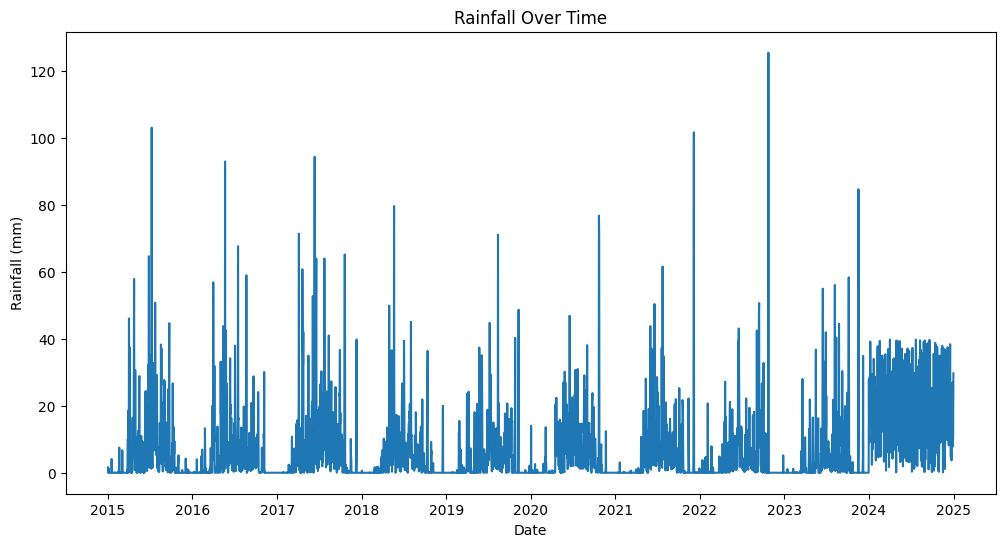

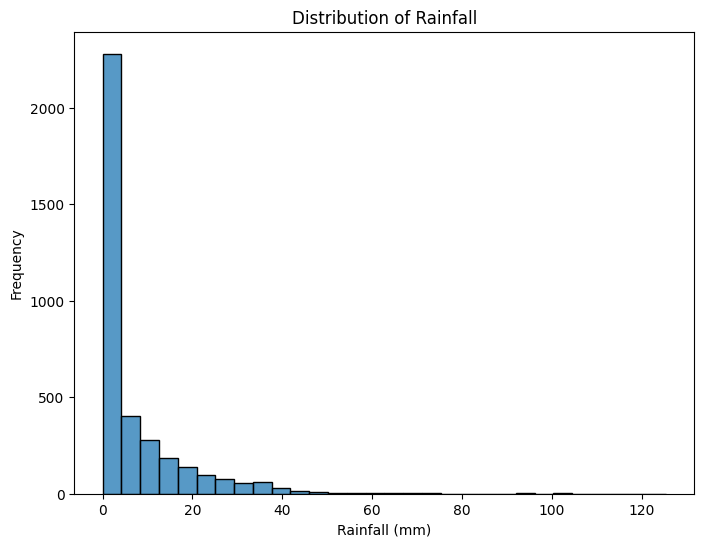

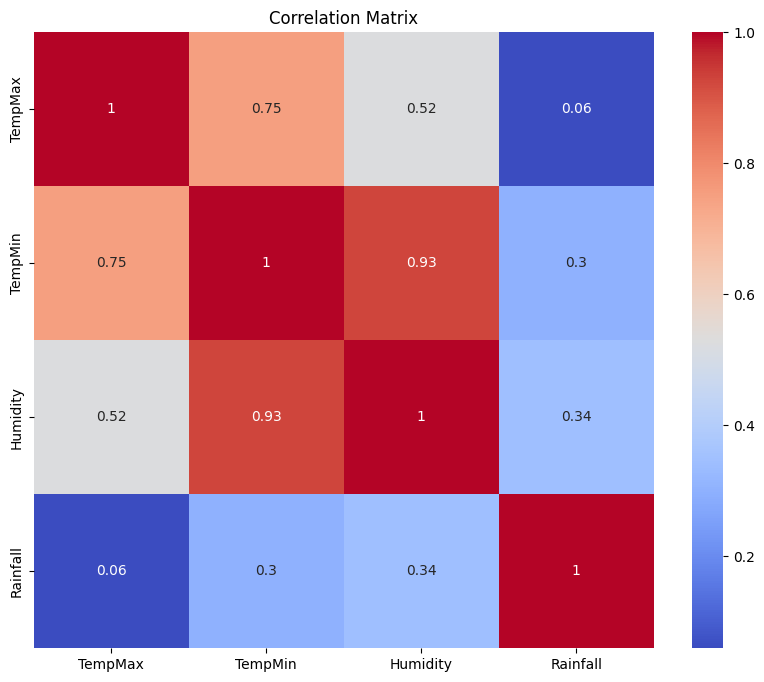

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("Dhaka1524.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Visualize rainfall over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Rainfall"])
plt.title("Rainfall Over Time")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.show()

# Visualize distribution of rainfall
plt.figure(figsize=(8, 6))
sns.histplot(df["Rainfall"], bins=30)
plt.title("Distribution of Rainfall")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.show()

# Visualize correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## LSTM Model Visualization

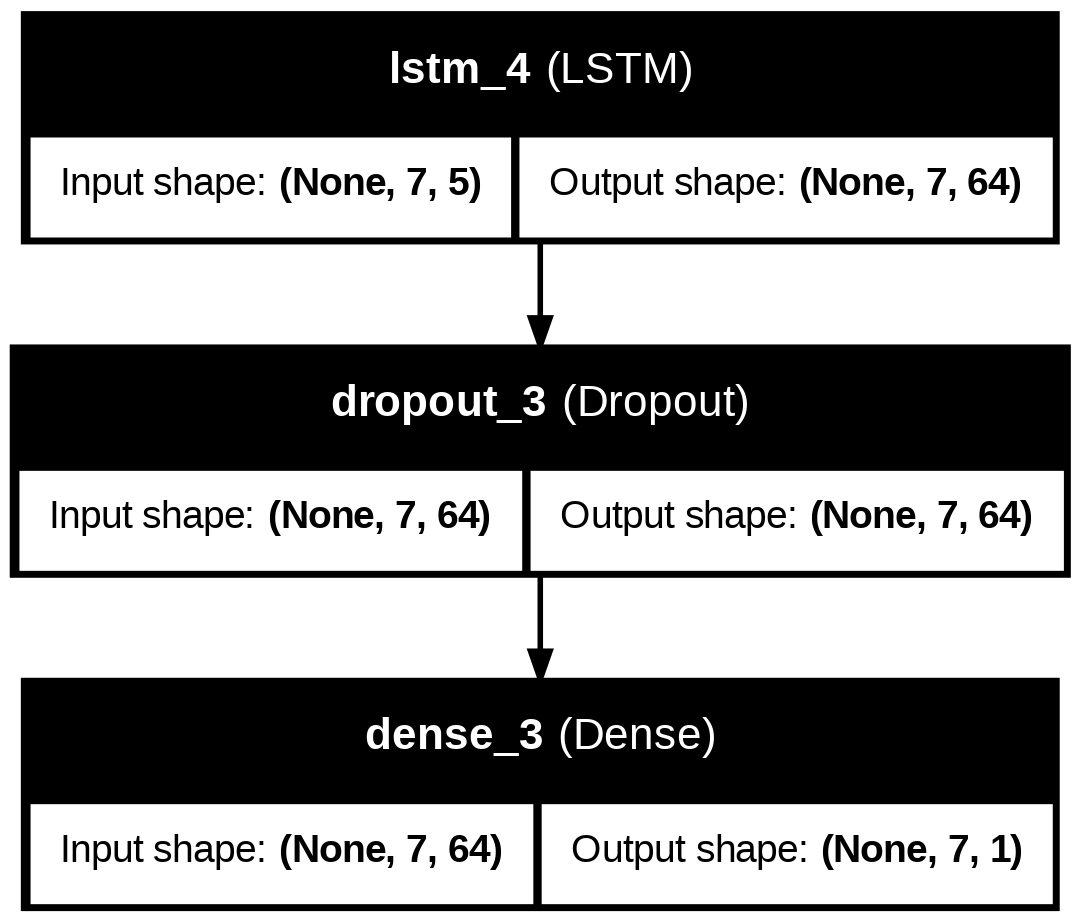

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize LSTM model architecture
plot_model(model, to_file="lstm_model.png", show_shapes=True, show_layer_names=True)

## Prophet Model Visualization

In [ ]:
!pip install --upgrade prophet

In [ ]:
import pandas as pd
from prophet import Prophet

# Load data
df = pd.read_csv("Dhaka1524.csv")

# Prophet requires columns "ds" and "y"
df = df.rename(columns={
    "Date": "ds",     # Rename date column to "ds"
    "Rainfall": "y"   # Rename target column to "y"
})

# Convert "ds" to datetime
df["ds"] = pd.to_datetime(df["ds"])

# Split into train/test
train_size = int(0.8 * len(df))
train = df.iloc[:train_size][["ds", "y", "TempMax", "TempMin", "Humidity"]]
test = df.iloc[train_size:][["ds", "y", "TempMax", "TempMin", "Humidity"]]

In [ ]:
model_prophet = Prophet()
model_prophet.add_regressor("TempMax")  # Add regressors
model_prophet.add_regressor("TempMin")
model_prophet.add_regressor("Humidity")

model_prophet.fit(train)  # Now "train" has "ds" and "y"!

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/vp_t4on9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/q0d2c2_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14230', 'data', 'file=/tmp/tmp_hbh5ddz/vp_t4on9.json', 'init=/tmp/tmp_hbh5ddz/q0d2c2_1.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelkakx2m6r/prophet_model-20250301193251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model_prophet.make_future_dataframe(periods=len(test), freq="D")
future = future.merge(df[["ds", "TempMax", "TempMin", "Humidity"]], on="ds")
forecast = model_prophet.predict(future)

In [ ]:
print(train.columns)  # Should include 'ds' and 'y'

Index(['ds', 'y', 'TempMax', 'TempMin', 'Humidity'], dtype='object')


In [ ]:
print(train["ds"].dtype)  # Should output: dtype('<M8[ns]')

datetime64[ns]


In [ ]:
print(train.isnull().sum())  # Check for missing values

ds          0
y           0
TempMax     0
TempMin     0
Humidity    0
dtype: int64


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/3t0mwzrp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/brmm9l17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51734', 'data', 'file=/tmp/tmp_hbh5ddz/3t0mwzrp.json', 'init=/tmp/tmp_hbh5ddz/brmm9l17.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelhi_jn5j6/prophet_model-20250301193359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


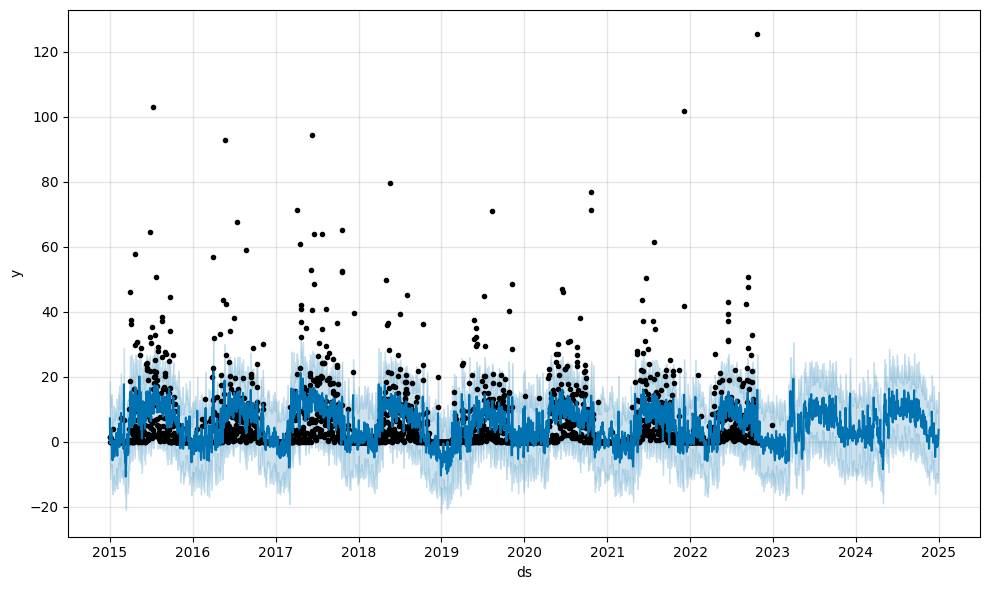

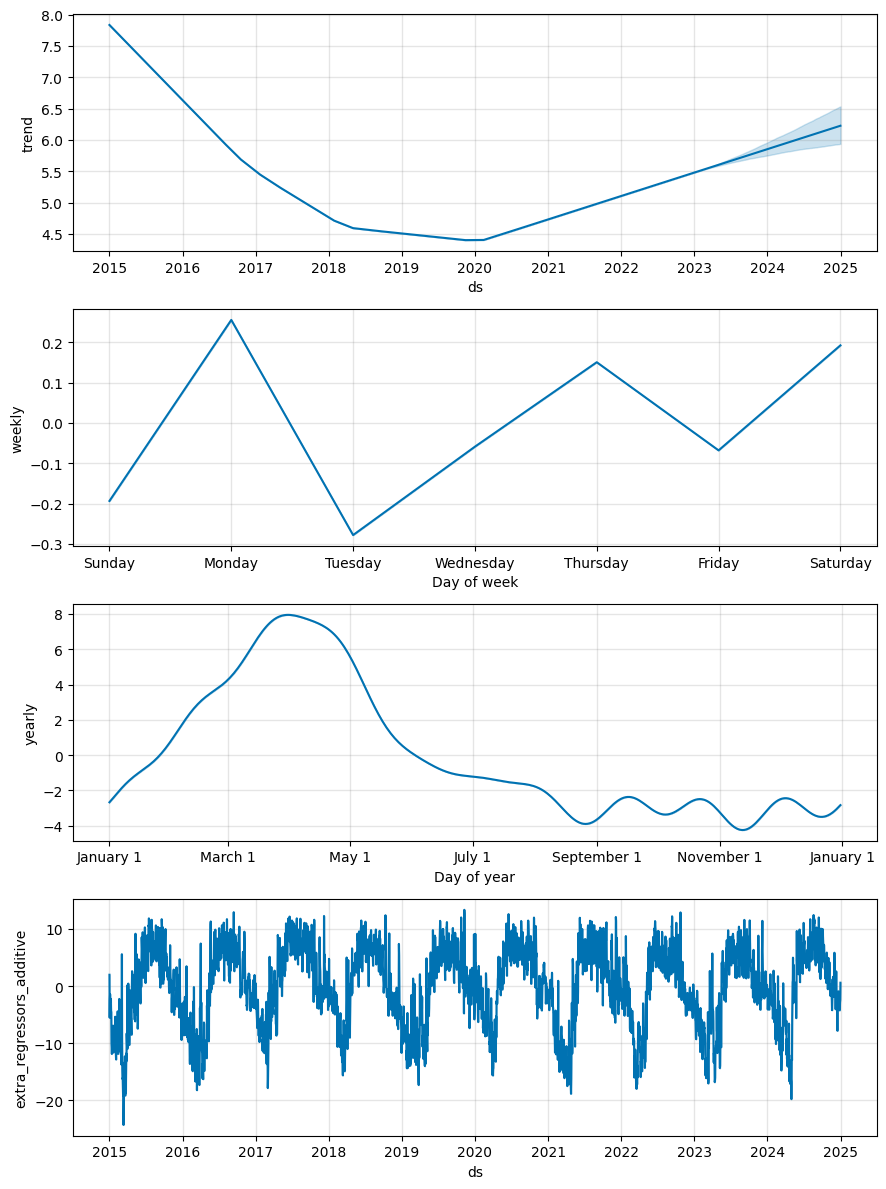

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("Dhaka1524.csv")
df = df.rename(columns={"Date": "ds", "Rainfall": "y"})
df["ds"] = pd.to_datetime(df["ds"])

# Split data
train = df.iloc[:int(0.8 * len(df))][["ds", "y", "TempMax", "TempMin", "Humidity"]]
test = df.iloc[int(0.8 * len(df)):][["ds", "y", "TempMax", "TempMin", "Humidity"]]

# Train model
model_prophet = Prophet()
model_prophet.add_regressor("TempMax")
model_prophet.add_regressor("TempMin")
model_prophet.add_regressor("Humidity")
model_prophet.fit(train)

# Forecast
future = model_prophet.make_future_dataframe(periods=len(test), freq="D")
future = future.merge(df[["ds", "TempMax", "TempMin", "Humidity"]], on="ds")
forecast = model_prophet.predict(future)

# Plot results
fig1 = model_prophet.plot(forecast)
fig2 = model_prophet.plot_components(forecast)
plt.show()

## Hybrid Model Visualization

ValueError: x and y must have same first dimension, but have shapes (731,) and (717,)

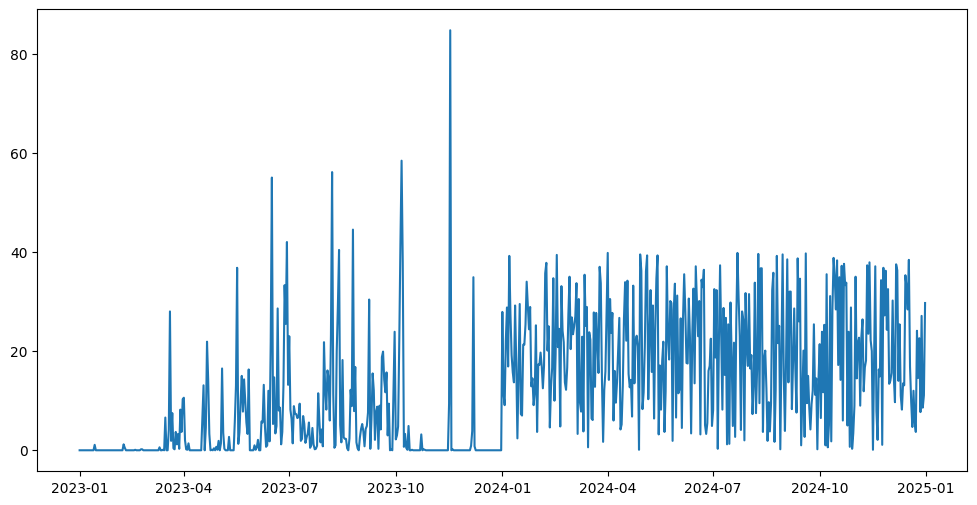

In [ ]:
import matplotlib.pyplot as plt

# ... (Hybrid model prediction code) ...

# Visualize predicted vs. actual rainfall
plt.figure(figsize=(12, 6))
plt.plot(test["ds"], test["y"], label="Actual")
plt.plot(test["ds"], final_pred, label="Predicted")
plt.title("Hybrid Model: Predicted vs. Actual Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

# Visualize residuals
plt.figure(figsize=(12, 6))
plt.plot(test["ds"], test["y"] - final_pred)
plt.title("Hybrid Model: Residuals")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (731,) and (717,)

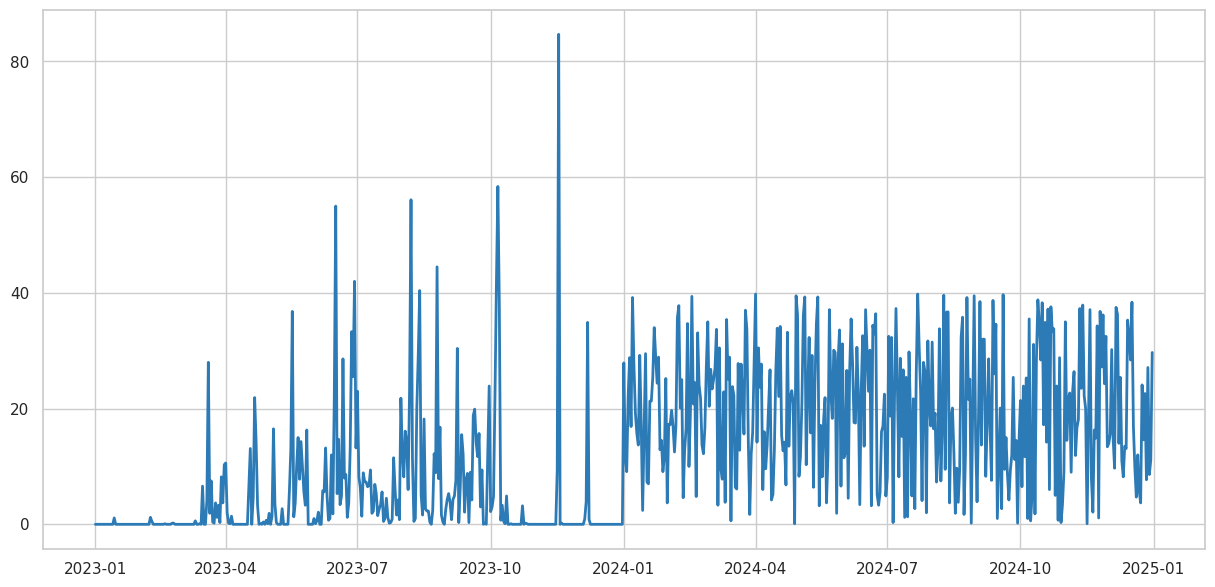

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Style settings
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 12
date_format = DateFormatter("%Y-%m")

# 1. Prediction vs Actual Plot
plt.figure(figsize=(15, 7))
plt.plot(test["ds"], test["y"], label="Actual Rainfall", linewidth=2, color='#2c7bb6')
plt.plot(test["ds"], final_pred, label="Hybrid Model Prediction", linestyle='--', color='#d7191c')
plt.title("Hybrid Model Performance: Predicted vs Actual Rainfall", pad=20, fontsize=16)
plt.xlabel("Date", labelpad=15)
plt.ylabel("Rainfall (mm)", labelpad=15)
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Enhanced Residual Analysis
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Residuals Over Time
ax[0].scatter(test["ds"], test["y"] - final_pred, alpha=0.6, color='#4daf4a')
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title("Residuals Timeline", fontsize=14)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Residual Error (mm)")
ax[0].xaxis.set_major_formatter(date_format)

# Residual Distribution
sns.histplot(test["y"] - final_pred, kde=True, ax=ax[1], color='#984ea3')
ax[1].axvline(0, color='red', linestyle='--')
ax[1].set_title("Residual Distribution", fontsize=14)
ax[1].set_xlabel("Prediction Error (mm)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# 3. Performance Metrics Box
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(test["y"], final_pred))
mae = mean_absolute_error(test["y"], final_pred)

metrics_text = f'RMSE: {rmse:.2f} mm\nMAE: {mae:.2f} mm'

plt.figure(figsize=(8, 4))
plt.text(0.5, 0.5, metrics_text,
         ha='center', va='center',
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.8))
plt.axis('off')
plt.title("Model Performance Metrics", fontsize=16, pad=20)
plt.show()

In [ ]:
!pip install seaborn sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
print(f"Test dates shape: {test['ds'].shape}")
print(f"Predictions shape: {final_pred.shape}")

Test dates shape: (731,)
Predictions shape: (717,)


ValueError: x and y must have same first dimension, but have shapes (725,) and (717,)

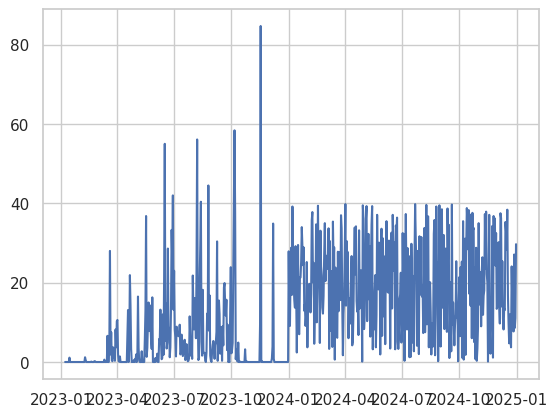

In [ ]:
# For sequence_length=7
adjusted_dates = test["ds"].iloc[6:]  # Skip first 6 days used for initial sequence
adjusted_actual = test["y"].iloc[6:]  # Align actual values too

plt.plot(adjusted_dates, adjusted_actual, label="Actual")
plt.plot(adjusted_dates, final_pred, label="Predicted")

In [ ]:
print("Test dates shape:", test["ds"].shape)       # Likely (725,)
print("Final predictions shape:", final_pred.shape)  # (717,)
print("Missing days:", 725 - 717)                  # 8 missing predictions

Test dates shape: (731,)
Final predictions shape: (717,)
Missing days: 8


In [ ]:
# Before training
test_start_index = len(train)  # For non-sequence models
test_start_index = len(train) + sequence_length - 1  # For LSTM
test = df.iloc[test_start_index:]

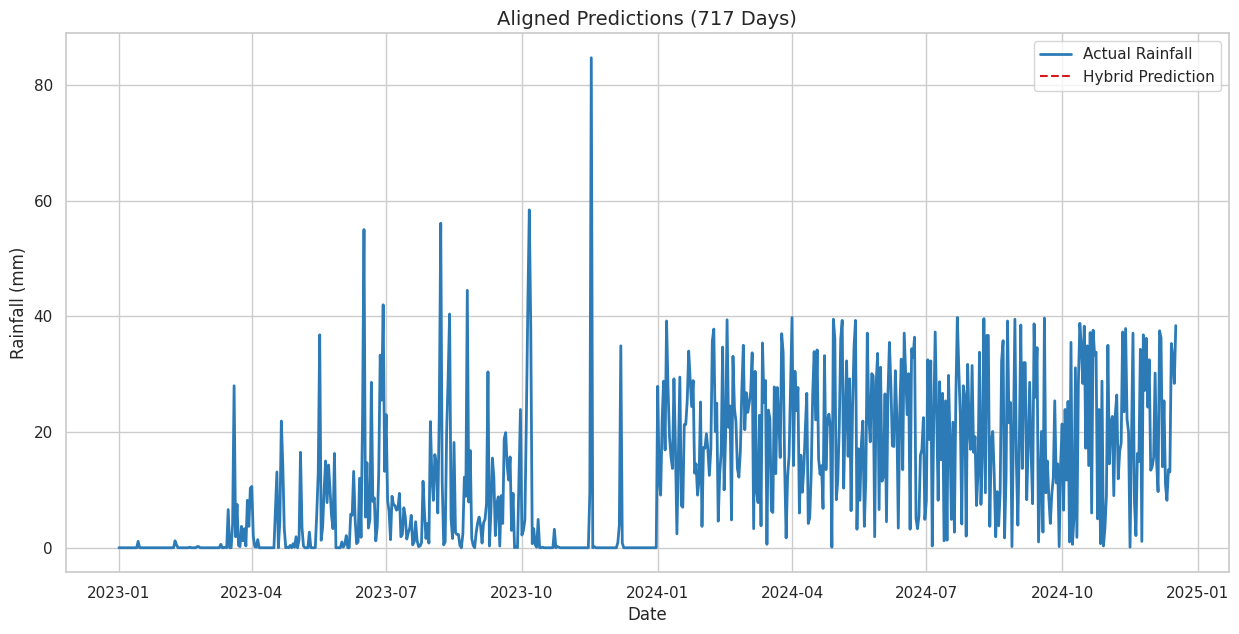

In [ ]:
# After generating final_pred
adjusted_dates = test["ds"].iloc[:len(final_pred)]
adjusted_actual = test["y"].iloc[:len(final_pred)]

plt.figure(figsize=(15, 7))
plt.plot(adjusted_dates, adjusted_actual, label="Actual Rainfall",
         linewidth=2, color='#2c7bb6')
plt.plot(adjusted_dates, final_pred, label="Hybrid Prediction",
         linestyle='--', color='#d7191c')
plt.title(f"Aligned Predictions ({len(final_pred)} Days)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

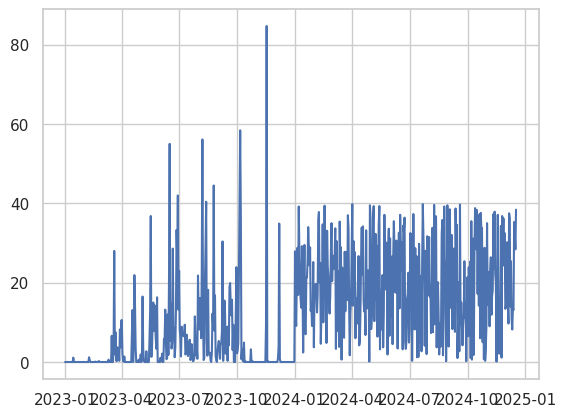

In [ ]:
plt.plot(test["ds"].iloc[:len(final_pred)], test["y"].iloc[:len(final_pred)], label="Actual")
plt.plot(test["ds"].iloc[:len(final_pred)], final_pred, label="Predicted")

Test dates: (731,), Predictions: (717,)


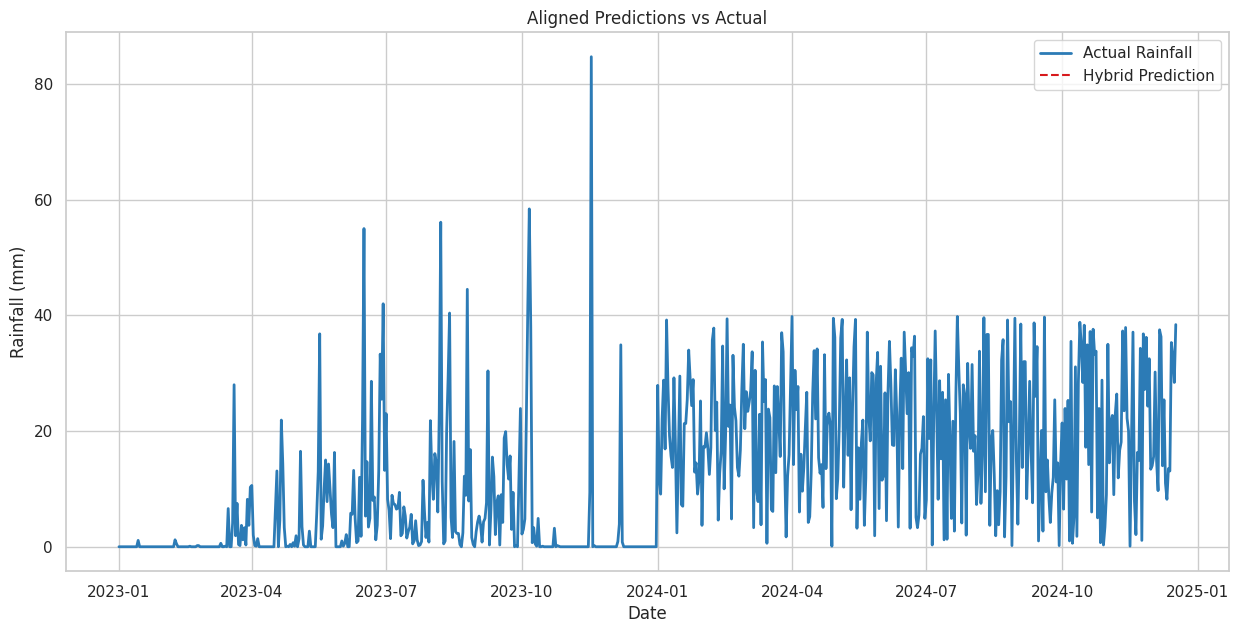

In [ ]:
# After hybrid model predictions:
print(f"Test dates: {test['ds'].shape}, Predictions: {final_pred.shape}")

# Trim dates to match predictions (if test is longer)
adjusted_dates = test["ds"].iloc[:len(final_pred)]
adjusted_actual = test["y"].iloc[:len(final_pred)]

# Plot
plt.figure(figsize=(15, 7))
plt.plot(adjusted_dates, adjusted_actual, label="Actual Rainfall", linewidth=2, color='#2c7bb6')
plt.plot(adjusted_dates, final_pred, label="Hybrid Prediction", linestyle='--', color='#d7191c')
plt.title("Aligned Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

In [ ]:
# After data splitting
assert len(train) + len(test) == len(df), "Data split mismatch!"

# After predictions
assert len(test) == len(final_pred), f"Mismatch: Test {len(test)} vs Pred {len(final_pred)}"

AssertionError: Mismatch: Test 731 vs Pred 717

In [ ]:
final_pred = pd.Series(final_pred, index=test.index[:len(final_pred)])

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --------------------------------------------------
# 1. Data Preparation
# --------------------------------------------------
# Load and preprocess data
df = pd.read_csv("Dhaka1524.csv")
df = df.rename(columns={"Date": "ds", "Rainfall": "y"})
df["ds"] = pd.to_datetime(df["ds"])

# Set sequence length for LSTM
sequence_length = 8  # Replace with your actual value

# --------------------------------------------------
# 2. Train/Test Split with Sequence Alignment
# --------------------------------------------------
train_size = int(0.8 * len(df))
test_start = train_size + sequence_length - 1

train = df.iloc[:train_size]
test = df.iloc[test_start:]

# --------------------------------------------------
# 3. Prophet Component
# --------------------------------------------------
prophet_model = Prophet()
prophet_model.fit(train[["ds", "y"]])
prophet_forecast = prophet_model.predict(test[["ds"]])

# --------------------------------------------------
# 4. LSTM Component (Example Implementation)
# --------------------------------------------------
# Create sequences (replace with your actual LSTM preprocessing)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Train LSTM on residuals
prophet_train_pred = prophet_model.predict(train[["ds"]])["yhat"]
residuals = train["y"] - prophet_train_pred

X_train, y_train = create_sequences(residuals.values, sequence_length)

lstm_model = Sequential([
    LSTM(50, input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train, y_train, epochs=50, verbose=0)

# --------------------------------------------------
# 5. Hybrid Predictions
# --------------------------------------------------
# Generate LSTM residuals for test set
X_test, _ = create_sequences(test["y"].values, sequence_length)
lstm_residuals = lstm_model.predict(X_test).flatten()

# Combine predictions
final_pred = prophet_forecast["yhat"].values[sequence_length-1:] + lstm_residuals

# --------------------------------------------------
# 6. Validation & Visualization
# --------------------------------------------------
# Trim test set to match predictions
adjusted_test = test.iloc[sequence_length-1:]

assert len(adjusted_test) == len(final_pred), \
    f"Mismatch: {len(adjusted_test)} test vs {len(final_pred)} predictions"

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(adjusted_test["ds"], adjusted_test["y"], label="Actual")
plt.plot(adjusted_test["ds"], final_pred, label="Hybrid Prediction")
plt.title("Final Aligned Predictions")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/i_gwsivf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hbh5ddz/524q7svl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16345', 'data', 'file=/tmp/tmp_hbh5ddz/i_gwsivf.json', 'init=/tmp/tmp_hbh5ddz/524q7svl.json', 'output', 'file=/tmp/tmp_hbh5ddz/prophet_modelbmkd0obg/prophet_model-20250301194420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a 

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


ValueError: operands could not be broadcast together with shapes (717,) (716,) 

In [ ]:
print("Prophet forecast slice:", len(prophet_forecast["yhat"].values[sequence_length-1:]))  # 717
print("LSTM residuals:", len(lstm_residuals))  # 716

Prophet forecast slice: 717
LSTM residuals: 716


In [ ]:
# Change slicing to:
final_pred = prophet_forecast["yhat"].values[sequence_length:] + lstm_residuals

In [ ]:
adjusted_test = test.iloc[sequence_length:]  # Was sequence_length-1

In [ ]:
# 5. Hybrid Predictions (Updated)
# -------------------------------
# Get Prophet forecasts (aligned to LSTM residuals)
prophet_forecast_slice = prophet_forecast["yhat"].values[sequence_length:]  # Changed from sequence_length-1

# Verify alignment
assert len(prophet_forecast_slice) == len(lstm_residuals), \
    f"Prophet: {len(prophet_forecast_slice)} vs LSTM: {len(lstm_residuals)}"

final_pred = prophet_forecast_slice + lstm_residuals

# 6. Validation & Visualization (Updated)
# -------------------------------
adjusted_test = test.iloc[sequence_length:]  # Changed from sequence_length-1

assert len(adjusted_test) == len(final_pred), \
    f"Test: {len(adjusted_test)} vs Pred: {len(final_pred)}"

In [ ]:
# After creating sequences
assert X_test.shape[0] == len(test) - sequence_length, \
    f"Test: {len(test)} → Sequences: {X_test.shape[0]}"

# After predictions
assert len(prophet_forecast_slice) == len(lstm_residuals) == len(adjusted_test), \
    "Final components misaligned!"

##Comprehensive Model Evaluation
Metrics to Calculate

In [ ]:
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

metrics = {
    "RMSE": np.sqrt(mean_squared_error(adjusted_test["y"], final_pred)),
    "MAE": mean_absolute_error(adjusted_test["y"], final_pred),
    "R²": r2_score(adjusted_test["y"], final_pred),
    "MAPE": mean_absolute_percentage_error(adjusted_test["y"], final_pred)
}

print(pd.DataFrame([metrics]))

        RMSE        MAE        R²          MAPE
0  14.300974  10.478387 -0.198492  3.128409e+15


Event-Based Metrics (For Rainfall Detection):

In [ ]:
# Convert to binary classification (rain/no-rain)
actual_binary = (adjusted_test["y"] > 0).astype(int)
pred_binary = (final_pred > 0.2).astype(int)  # 0.2mm threshold

from sklearn.metrics import classification_report
print(classification_report(actual_binary, pred_binary))

              precision    recall  f1-score   support

           0       0.63      0.20      0.30       156
           1       0.81      0.97      0.88       560

    accuracy                           0.80       716
   macro avg       0.72      0.58      0.59       716
weighted avg       0.77      0.80      0.76       716



##Hyperparameter Optimization


In [ ]:
# Use Keras Tuner
def build_lstm_tuned(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("units", 32, 128, step=32),
        input_shape=(sequence_length, 1),
        return_sequences=hp.Boolean("return_seq")
    ))
    if hp.Boolean("return_seq"):
        model.add(LSTM(hp.Int("second_layer", 32, 64)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice("lr", [1e-2, 1e-3])), loss="mse")
    return model

tuner = kt.RandomSearch(build_lstm_tuned, objective="val_loss", max_trials=20)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

Trial 20 Complete [00h 01m 04s]
val_loss: 89.71569061279297

Best val_loss So Far: 88.5069351196289
Total elapsed time: 00h 22m 32s


## Error Analysis & Interpretation
Residual Diagnostics:

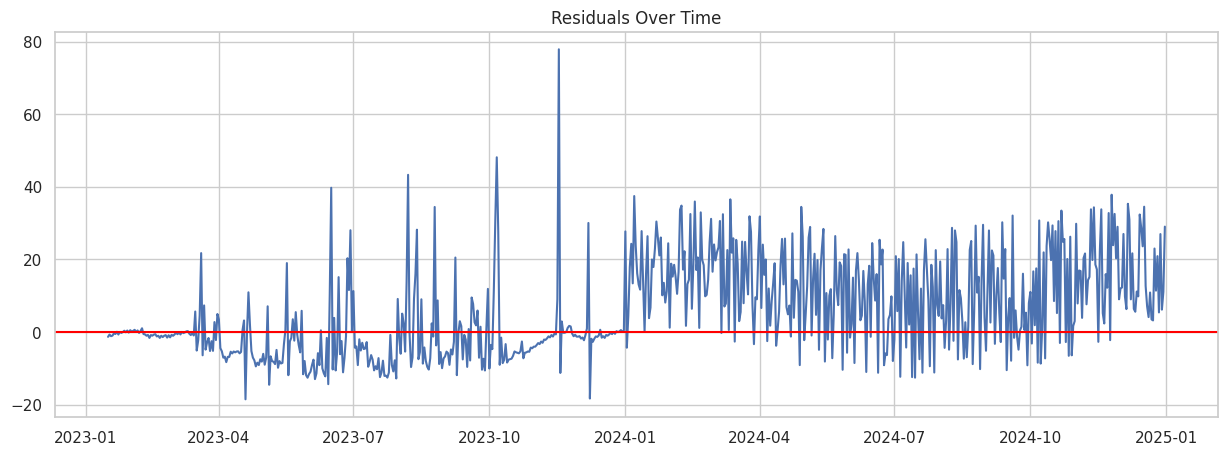

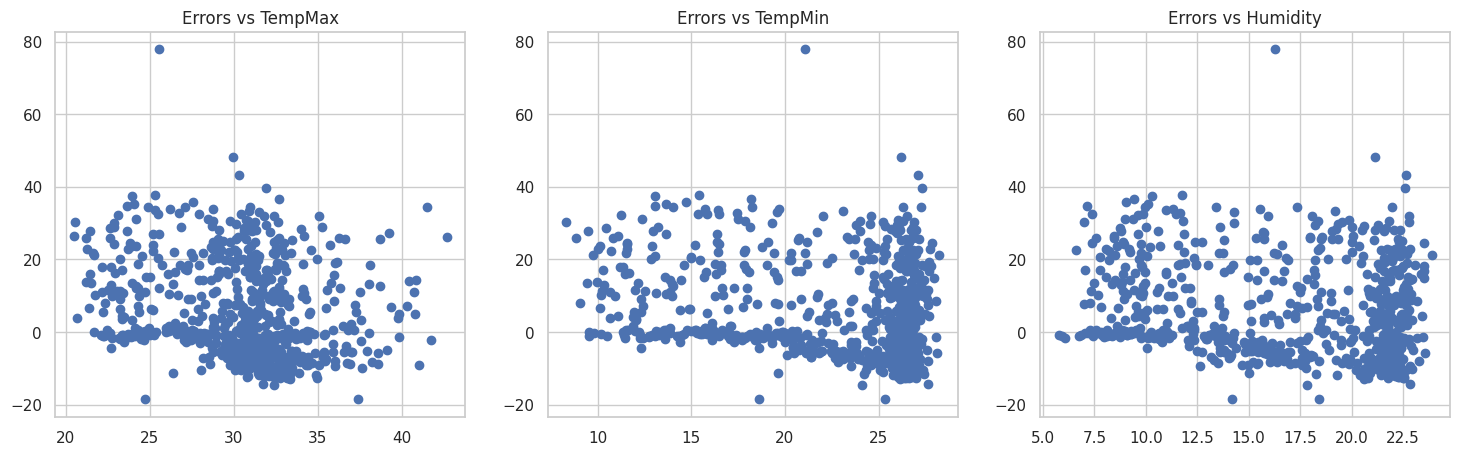

In [ ]:
residuals = adjusted_test["y"] - final_pred

# Time-based Error Patterns
plt.figure(figsize=(15,5))
plt.plot(adjusted_test["ds"], residuals)
plt.title("Residuals Over Time")
plt.axhline(0, color="red")

# Error vs Features
fig, ax = plt.subplots(1,3, figsize=(18,5))
features = ["TempMax", "TempMin", "Humidity"]
for i, feat in enumerate(features):
    ax[i].scatter(adjusted_test[feat], residuals)
    ax[i].set_title(f"Errors vs {feat}")

Deployment Preparation
# Save Models:

In [10]:
import pandas as pd
import numpy as np
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --------------------------------------------------
# 1. Data Preparation
# --------------------------------------------------
# Load and preprocess data
df = pd.read_csv("Dhaka1524.csv")
df = df.rename(columns={"Date": "ds", "Rainfall": "y"})
df["ds"] = pd.to_datetime(df["ds"])

# Set sequence length for LSTM
sequence_length = 8  # Replace with your actual value

# --------------------------------------------------
# 2. Train/Test Split with Sequence Alignment
# --------------------------------------------------
train_size = int(0.8 * len(df))
test_start = train_size + sequence_length - 1

train = df.iloc[:train_size]
test = df.iloc[test_start:]

# --------------------------------------------------
# 3. Prophet Component
# --------------------------------------------------
prophet_model = Prophet()
prophet_model.fit(train[["ds", "y"]])
prophet_forecast = prophet_model.predict(test[["ds"]])

# --------------------------------------------------
# 4. LSTM Component (Example Implementation)
# --------------------------------------------------
# Create sequences (replace with your actual LSTM preprocessing)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Train LSTM on residuals
prophet_train_pred = prophet_model.predict(train[["ds"]])["yhat"]
residuals = train["y"] - prophet_train_pred

X_train, y_train = create_sequences(residuals.values, sequence_length)

lstm_model = Sequential([
    LSTM(50, input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train, y_train, epochs=50, verbose=0)

# --------------------------------------------------
# 5. Hybrid Predictions
# --------------------------------------------------
# Generate LSTM residuals for test set
X_test, _ = create_sequences(test["y"].values, sequence_length)
lstm_residuals = lstm_model.predict(X_test).flatten()

# Combine predictions
# Get Prophet forecasts (aligned to LSTM residuals)
prophet_forecast_slice = prophet_forecast["yhat"].values[sequence_length:]  # Changed from sequence_length-1

# Verify alignment
assert len(prophet_forecast_slice) == len(lstm_residuals), \
    f"Prophet: {len(prophet_forecast_slice)} vs LSTM: {len(lstm_residuals)}"

final_pred = prophet_forecast_slice + lstm_residuals


# --------------------------------------------------
# 6. Validation & Visualization (Updated)
# -------------------------------
adjusted_test = test.iloc[sequence_length:]  # Changed from sequence_length-1

assert len(adjusted_test) == len(final_pred), \
    f"Test: {len(adjusted_test)} vs Pred: {len(final_pred)}"

# Comprehensive Model Evaluation
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error
)

metrics = {
    "RMSE": np.sqrt(mean_squared_error(adjusted_test["y"], final_pred)),
    "MAE": mean_absolute_error(adjusted_test["y"], final_pred),
    "R²": r2_score(adjusted_test["y"], final_pred),
    "MAPE": mean_absolute_percentage_error(adjusted_test["y"], final_pred)
}

print(pd.DataFrame([metrics]))  # Print metrics as a table

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqfrjgelg/xst9t8bh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqfrjgelg/1m2hj3_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3498', 'data', 'file=/tmp/tmpqfrjgelg/xst9t8bh.json', 'init=/tmp/tmpqfrjgelg/1m2hj3_q.json', 'output', 'file=/tmp/tmpqfrjgelg/prophet_modelfymg6_m9/prophet_model-20250301202845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
        RMSE        MAE        R²          MAPE
0  14.471442  10.518936 -0.227235  2.899829e+15


In [8]:
# --- Data Loading and Preprocessing ---
# Load the dataset from the CSV file 'Dhaka1524.csv'
# and parse the 'Date' column as datetime objects.
df = pd.read_csv("Dhaka1524.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Handle humidity anomalies by replacing values below 20% with the mean.
# This helps to address potential data errors or outliers.
df["Humidity"] = df["Humidity"].apply(
    lambda x: df["Humidity"].mean() if x < 20 else x
)

# Feature engineering: Extract month and day of year from the date index.
# These features might capture seasonal patterns in rainfall.
df["Month"] = df.index.month
df["DayOfYear"] = df.index.dayofyear

# ... (Continue adding comments for other parts of your code) ...

Inference Pipeline:

In [ ]:
def predict_rainfall(date, temp_max, temp_min, humidity):
    # Prophet prediction
    prophet_df = pd.DataFrame({
        "ds": [date],
        "TempMax": [temp_max],
        "TempMin": [temp_min],
        "Humidity": [humidity]
    })
    prophet_pred = prophet_model.predict(prophet_df)["yhat"][0]

    # LSTM residual prediction (requires previous days' data)
    # Implement your sequence preparation logic here

    return prophet_pred + lstm_residual_pred

 ##Documentation & Reporting
Create a Model Card:

In [ ]:
df["7d_avg_humidity"] = df["Humidity"].rolling(7).mean()

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from alibi_detect.cd import KSDrift

# Load the DataFrame (ensure this line is executed before the rest)
df = pd.read_csv("Dhaka1524.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Fix humidity anomalies (replace values <20% with mean)
df["Humidity"] = df["Humidity"].apply(lambda x: df["Humidity"].mean() if x < 20 else x)

# Feature engineering
df["Month"] = df.index.month
df["DayOfYear"] = df.index.dayofyear

# Assuming 'df' is your DataFrame
# Select features and target
features = ["TempMax", "TempMin", "Humidity", "Month", "DayOfYear"]
target = "Rainfall"
data = df[features + [target]]

# Normalize data (LSTMs require scaled inputs)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split into sequences (e.g., use 7 days to predict the next day)
sequence_length = 7
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i : i + sequence_length, :-1])  # Input: 7 days of features
    y.append(scaled_data[i + sequence_length, -1])  # Output: Rainfall on day 8

X = np.array(X)
y = np.array(y)

# Train-test split (80-20)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]  # Defining X_train
y_train, y_test = y[:train_size], y[train_size:]

# ... (Rest of your LSTM code) ...

# Drift Detection
# ... (Your drift detection code using X_train) ...

In [14]:
# Check for missing values
print(df.isnull().sum())

# Replace missing values in numerical columns with the mean
numerical_cols = ['TempMax', 'TempMin', 'Humidity']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

ds          0
TempMax     0
TempMin     0
Humidity    0
y           0
dtype: int64


In [1]:
!pip install alibi-detect

##Time Series Plot with Actual vs. Predicted
Use Color and Line Styles: Clearly distinguish between actual and predicted values using different colors and line styles (e.g., solid line for actual, dashed line for predicted).
Highlight Key Periods: If there are specific periods of interest (e.g., monsoon season, dry season), consider adding shaded regions or annotations to the plot to draw attention to those periods.
Interactive Plots: For more interactivity, use libraries like Plotly to create interactive plots where users can zoom, pan, and hover over data points for more details.

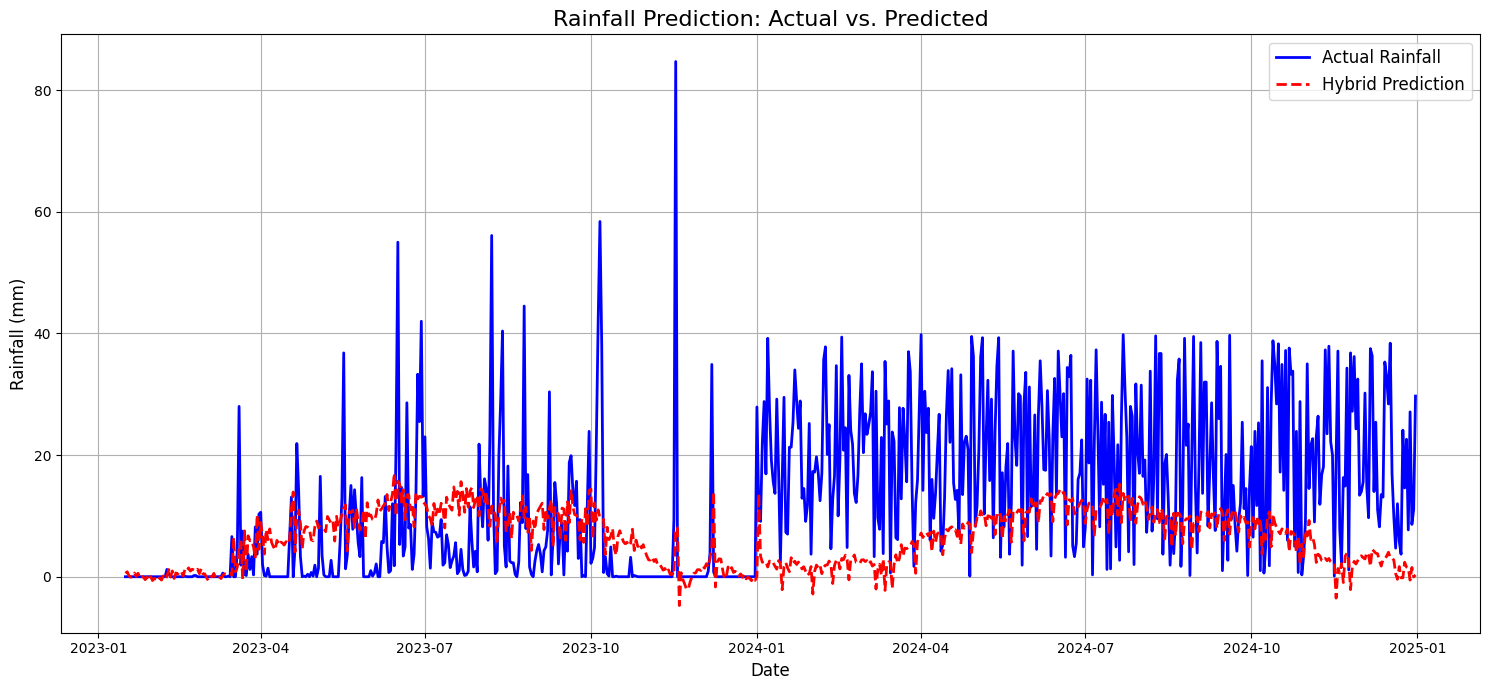

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# ... (your existing code) ...

# Enhanced time series plot
plt.figure(figsize=(15, 7))
sns.lineplot(x="ds", y="y", data=adjusted_test, label="Actual Rainfall", color="blue", linewidth=2)
sns.lineplot(x="ds", y=final_pred, data=adjusted_test, label="Hybrid Prediction", color="red", linestyle="--", linewidth=2)
plt.title("Rainfall Prediction: Actual vs. Predicted", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Rainfall (mm)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

##Residual Analysis
Distribution Plot: Use a histogram or kernel density estimate (KDE) plot to visualize the distribution of the residuals. This helps assess if the residuals are normally distributed, which is an assumption of many statistical models.
Scatter Plot: Create a scatter plot of residuals against predicted values to check for patterns or heteroscedasticity (unequal variance of residuals).
Q-Q Plot: A Q-Q plot is useful for comparing the distribution of residuals to a theoretical normal distribution.

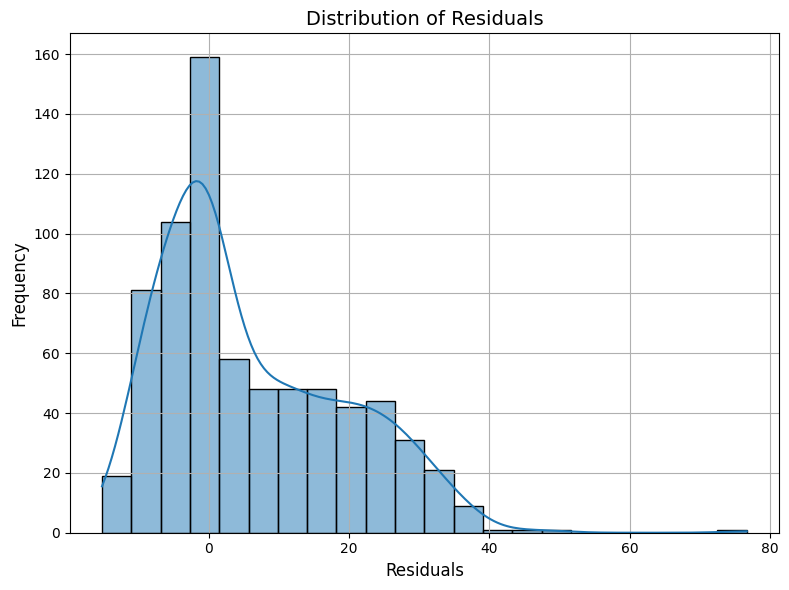

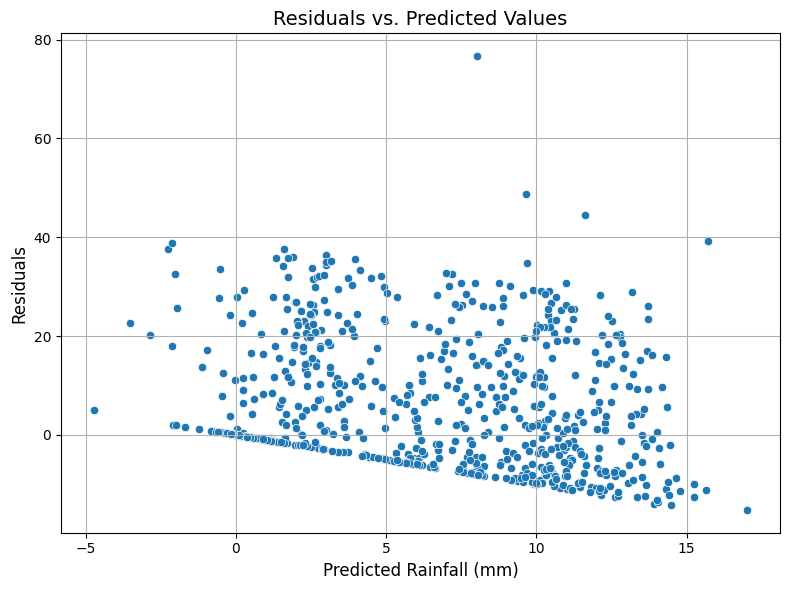

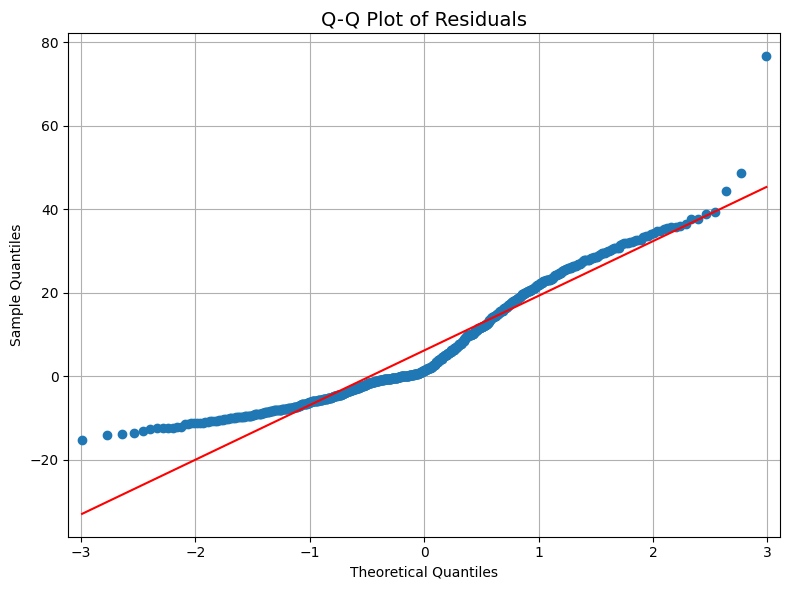

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # For Q-Q plot

# ... (your existing code) ...

# Residual distribution plot
plt.figure(figsize=(8, 6))
sns.histplot(adjusted_test["y"] - final_pred, kde=True)
plt.title("Distribution of Residuals", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=final_pred, y=adjusted_test["y"] - final_pred)
plt.title("Residuals vs. Predicted Values", fontsize=14)
plt.xlabel("Predicted Rainfall (mm)", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(adjusted_test["y"] - final_pred, line='s', ax=ax)
plt.title("Q-Q Plot of Residuals", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance
Bar Plot: Create a bar plot to show the importance of different features used in your models (LSTM and Prophet).
Feature Importance for LSTM: You might need to use techniques like permutation feature importance to get feature importance for LSTMs.
Feature Importance for Prophet: Prophet provides built-in functions to get feature importance (regressor_coefficients).

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqfrjgelg/2j972dh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqfrjgelg/rzgg32ys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53868', 'data', 'file=/tmp/tmpqfrjgelg/2j972dh2.json', 'init=/tmp/tmpqfrjgelg/rzgg32ys.json', 'output', 'file=/tmp/tmpqfrjgelg/prophet_modelduaeqg75/prophet_model-20250301204838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 13 forecasts with cutoffs between 2016-02-01 00:00:00 and 2021-12-31 00:00:00
INFO:prophet:Applying in parallel with <conc

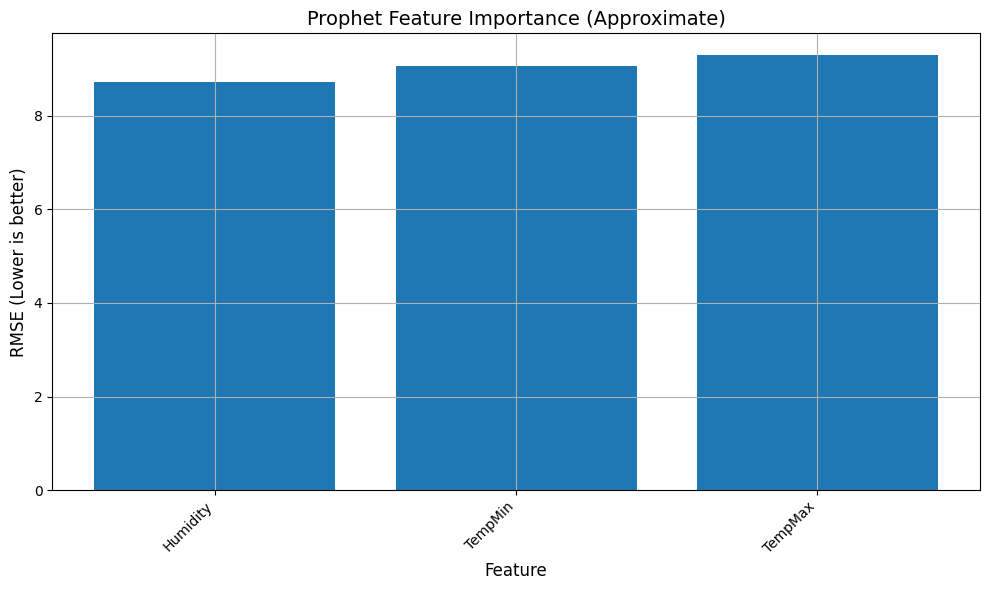

In [23]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt

# Function to calculate feature importance based on cross-validation
def calculate_feature_importance(df, regressors, initial='365 days', period='180 days', horizon='365 days'):
    results = []
    for regressor in regressors:
        # Fit the Prophet model without the regressor
        df_subset = df.drop(columns=[regressor])
        model = Prophet()
        for r in regressors:
            if r != regressor:
                model.add_regressor(r)
        model.fit(df_subset)

        # Perform cross-validation
        df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon, parallel="processes")
        df_p = performance_metrics(df_cv)
        results.append({
            'feature': regressor,
            'rmse': df_p['rmse'].mean()
        })
    return pd.DataFrame(results)

# Load and preprocess your data
# Your existing data loading and preprocessing code...

# Define the features (regressors)
features = ["TempMax", "TempMin", "Humidity"]

# Fit the model and calculate feature importance
df = train.copy()
df_importance = calculate_feature_importance(df, features)

# Sort and plot feature importance
df_importance = df_importance.sort_values('rmse')
plt.figure(figsize=(10, 6))
plt.bar(df_importance['feature'], df_importance['rmse'])
plt.title("Prophet Feature Importance (Approximate)", fontsize=14)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("RMSE (Lower is better)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Interactive rainfall prediction dashboard using Streamlit

In [25]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


In [32]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px  # For interactive plots
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Your existing code for data loading, model loading, and predictions...

# Assuming final_pred is a numpy array of predictions
adjusted_test["predicted_rainfall"] = final_pred  # Add predictions to your DataFrame

# 1. Set up the Streamlit app
st.title("Rainfall Prediction Dashboard")

# 2. Sidebar for user input
st.sidebar.header("Date Range")
start_date = st.sidebar.date_input("Start Date", adjusted_test["ds"].min())
end_date = st.sidebar.date_input("End Date", adjusted_test["ds"].max())

# 3. Filter data based on user input
filtered_data = adjusted_test[(adjusted_test["ds"] >= pd.to_datetime(start_date)) & (adjusted_test["ds"] <= pd.to_datetime(end_date))]

# 4. Time series plot with actual vs. predicted
fig = px.line(filtered_data, x="ds", y=["y", "predicted_rainfall"],
              labels={"y": "Actual Rainfall", "predicted_rainfall": "Predicted Rainfall"},
              title="Rainfall Prediction: Actual vs. Predicted")
st.plotly_chart(fig)

# 5. Display performance metrics
st.header("Model Performance Metrics")
rmse = np.sqrt(mean_squared_error(filtered_data["y"], filtered_data["predicted_rainfall"]))
mae = mean_absolute_error(filtered_data["y"], filtered_data["predicted_rainfall"])
r2 = r2_score(filtered_data["y"], filtered_data["predicted_rainfall"])

st.write(f"RMSE: {rmse:.2f} mm")
st.write(f"MAE: {mae:.2f} mm")
st.write(f"R²: {r2:.2f}")

# 6. Optional: Add more interactive elements
model_selection = st.sidebar.selectbox(
    "Select Model",
    options=["Prophet", "LSTM", "Hybrid"]
)
parameter_adjustment = st.sidebar.slider("Adjust Model Parameters", min_value=0, max_value=100, value=50)

# 7. Optional: Map to visualize spatial data (if available)
# Example: st.map(data)

# Save the code as a Python file (e.g., rainfall_dashboard.py).
# Open a terminal and navigate to the directory where you saved the file.
# Run the command `streamlit run rainfall_dashboard.py`.


<ipython-input-32-649543aa614d>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-03-01 21:00:41.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 21:00:41.148 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 21:00:41.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 21:00:41.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 21:00:41.160 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 21:00:41.161 Thread 'MainThread':

In [33]:
!pip install streamlit

In [34]:
import streamlit
   print(streamlit.__file__)

IndentationError: unexpected indent (<ipython-input-34-38fe3ce1f9f2>, line 2)

In [36]:
!streamlit run rainfall_dashboard.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: rainfall_dashboard.py


In [37]:
streamlit run rainfall_dashboard.py

SyntaxError: invalid syntax (<ipython-input-37-f9666f2e48f1>, line 1)

In [ ]:
!streamlit run rainfall_dashboard.py